# Analysing differences in incident classification performance using a CNN-KNN model with various pre-trained CNNs

This notebook accompanies a project report written for the Data Science course at the University of Twente.

- Project: CIRI
- Quartile: 2022-1B
- Authors:
  - Stijn Berendse (s.e.berendse@student.utwente.nl)
  - Gilian Schrijver (g.schrijver@student.utwente.nl)
- Project group number: 111

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import math

from tqdm import tqdm
from enum import Enum
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

## Parameters

_Any parameters applicable to this notebook shall be set here._

In [2]:
NUMBER_OF_FOLDS = 5

## Generic setup

Set the device. Using CUDA on CUDA-enabled devices speeds up the use of convolutional networks significantly.

In [3]:
cuda_enabled = torch.cuda.is_available()

if cuda_enabled:
    device = torch.device("cuda:0")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [4]:
rng = np.random.default_rng(0)

## Load datasets

The images were pre-processed in a different notebook, which means they must now be loaded into this one. To do so, we first define a class that helps in loading the data from the file system. This class was taken from https://medium.com/codex/saving-and-loading-transformed-image-tensors-in-pytorch-f37b4daa9658.

In [5]:
class PreparedData(torch.utils.data.Dataset):
    def __init__(self, img, mask):
        self.img = img  #img path
        self.mask = mask  #mask path
        self.len = len(os.listdir(self.img))

    def __getitem__(self, index):
        ls_img = sorted(os.listdir(self.img))
        ls_mask = sorted(os.listdir(self.mask))

        img_file_path = os.path.join(self.img, ls_img[index])
        img_tensor = torch.load(img_file_path)

        mask_file_path = os.path.join(self.mask, ls_mask[index])
        mask_tensor = torch.load(mask_file_path)

        return img_tensor, mask_tensor

    def __len__(self):
        return self.len

The class defined above is used to create Torch `Dataset`-like objects for the data that was saved to the file system by the other notebook. It constitutes data representing folds for K-Fold cross validation.

In [6]:
data = {}

for i in tqdm(range(NUMBER_OF_FOLDS)):
    data[i] = PreparedData(
        f"./content/fold{i}_loader/img",
        f"./content/fold{i}_loader/target"
    )

with open("./content/data_classes.bin", "rb") as file:
    data_classes = pickle.load(file)

100%|██████████| 5/5 [00:00<00:00, 441.97it/s]


In order to avoid repeating ourselves, a custom `Dataset` class is created that encapsulates multiple Torch `Dataset` objects, as well as dataloaders, targets, class names, etc. This will reduce unnecessary computations and reduce the number of variables that needs to be passed between functions.

In [7]:
class Dataset:
    """
    Represents a dataset from which data, targets and dataloaders can be easily
    extracted. Used mostly as a Data Transfer Object (DTO) to reduce the need
    to pass high numbers of parameters to other functions.
    """

    def __init__(self, datasets, classes):
        """
        Keyword arguments:
        datasets -- dictionary of dataset labels mapped to corresponding Datasets
                    Examples of labels can be "test", "train", "fold1", etc.
        classes  -- a list of all classes that exist in the Datasets
        """
        self.data = datasets
        self.all_classes = classes

        self.targets = {}
        for label, data in self.data.items():
            self.targets[label] = self._get_targets(data)

        self.dataloaders = {}
        for label, data in tqdm(self.data.items()):
            self.dataloaders[label] = DataLoader(
                data,
                batch_size=4,
                shuffle=False
            )

    def _get_targets(self, dataset):
        """Returns the list of targets for a specific dataset."""
        return [target for (_, target) in dataset]

We now use the class defined above to create a DTO for the `PreparedData` objects previously created for each fold.

In [8]:
dataset = Dataset(data, data_classes)

100%|██████████| 5/5 [00:00<00:00, 5674.11it/s]


## Initialize models

We will be comparing multiple models from torchvision, repeating largely equivalent steps for each model. To facilitate the reuse of code and to avoid repeating ourselves, we create a generic `Model` (abstract) class that will be implemented for each torchvision model. Subsequent code can rely on a single, generic interface provided by the `Model` class and need not worry about implementation details.

In [9]:
class Model():
    """
    Represents a generic convolutional model that is used for transfer
    learning, from which descriptors can be extracted for classification.
    """

    def __init__(self, model, name):
        self.model = model
        self.name = name

        for param in self.model.parameters():
            # As the model will not be trained, gradients are not required.
            # Disabling them speeds up performance.
            param.requires_grad = False

        self.model.eval()
        self.remove_classifier()

    def remove_classifier(self):
        """
        Removes the last fully connected layer (the classifier) from the
        model, allowing the extraction of descriptors.
        """
        raise NotImplementedError()

    def to(self, device):
        """Moves the model to the specified device."""
        self.model = self.model.to(device)

    def descriptors(self, dataloader, as_numpy=True):
        """
        Returns the output of the model for all items in the dataloader.
        """
        outputs = []
        with torch.no_grad():
            for data, targets in tqdm(dataloader):
                data = data.to(device)
                output = self.model(data).detach()
                outputs.extend(output)

        if as_numpy:
            outputs = np.array([output.cpu().numpy() for output in outputs])

        return outputs

Later on, we might want to loop over a list of models and perform a function for each of them. Therefore, we initialise a list to which an instance of each model will be appended.

In [10]:
models = []

### VGG16

In [11]:
class Vgg16Model(Model):
    def __init__(self):
        model = torchvision.models.vgg16(weights="DEFAULT")
        super().__init__(model, "VGG16")

    def remove_classifier(self):
        self.model.classifier = nn.Identity()


vgg16 = Vgg16Model()
vgg16.to(device)

models.append(vgg16)

### Inception V3

In [12]:
class InceptionV3Model(Model):
    def __init__(self):
        model = torchvision.models.inception_v3(weights="DEFAULT")
        super().__init__(model, "InceptionV3")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


inception = InceptionV3Model()
inception.to(device)

models.append(inception)

### ResNet-50

In [13]:
class ResNet50Model(Model):
    def __init__(self):
        model = torchvision.models.resnet50(weights="DEFAULT")
        super().__init__(model, "ResNet-50")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


resnet = ResNet50Model()
resnet.to(device)

models.append(resnet)

### ResNet-18

In [14]:
class ResNet18Model(Model):
    def __init__(self):
        model = torchvision.models.resnet18(weights="DEFAULT")
        super().__init__(model, "ResNet-18")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


resnet = ResNet18Model()
resnet.to(device)

models.append(resnet)

## Baseline

### Obtain image descriptors

Extracting image descriptors from pre-trained CNNs is a fairly time-consuming process. Therefore, we prefer doing this as infrequently as possible. The `DescriptorManager` class shall help achieve this goal. It provides functionality for saving extracted descriptors to the file system and loading descriptors from the file system, and provides a `get_descriptors` function that extracts or loads descriptors based on whichever is possible.

In [15]:
class DescriptorManager:
    """
    Handles the loading, saving and extraction of data descriptors.
    """

    def __init__(self, model, base_path="./data/descriptors"):
        self.model = model
        self.base_path = base_path
        self.descriptors = {}

    def _create_path(self, label):
        """
        Creates a standardised path for descriptors with the provided model name
        and label to prevent inconsistencies between loading and saving descriptors.
        """
        return f"{self.base_path}/{self.model.name}/descriptors_{label}.bin"

    def save_descriptors(self, descriptors, label):
        """
        Saves the provided descriptor to the file system at a path derived from
        the model name and label.
        """
        path = self._create_path(label)
        os.makedirs(os.path.dirname(path), exist_ok=True)

        with open(path, "wb") as file:
            pickle.dump(descriptors, file)

    def extract_descriptors(self, dataloader, label):
        """
        Extracts descriptors from the provided model and saves them to this
        DescriptorManager.
        """
        descriptors = self.model.descriptors(dataloader, True)
        self.descriptors[label] = descriptors

        return descriptors

    def load_descriptors(self, label):
        """
        Loads and returns the provided descriptors from the file system, based
        on the provided model name and label.
        """
        path = self._create_path(label)

        with open(path, "rb") as file:
            self.descriptors[label] = pickle.load(file)

            return self.descriptors[label]

    def get_descriptors(self, dataloader, label):
        """
        Returns cached descriptors, returns descriptors from the file system or
        extracts and saves new descriptors from the model, based on which is
        available.

        Keyword arguments:
        dataloader -- DataLoader with data for which descriptors are retrieved
        label -- the label for this data (e.g. "train", "test", "fold1", etc.)
        """
        if label in self.descriptors:
            return self.descriptors[label]

        try:
            return self.load_descriptors(label)
        except FileNotFoundError:
            descriptors = self.extract_descriptors(dataloader, label)
            self.save_descriptors(descriptors, label)

            return descriptors

### Perform K-Nearest Neighbors (KNN) classification

We want to assess the classification performance using different numbers of neighbours, hence define them here.

In [16]:
n_neighbors_list = [1, 2, 5, 10, 15, 20, 30, 40, 50, 75, 100]

For each `n_neighbors` in the defined list, we perform classification and calculate the accuracy.

In [17]:
class DescriptorAssessor:
    def __init__(self, descriptor_manager):
        self.descriptor_manager = descriptor_manager

    def _get_descriptors(self, dataset, data_types):
        descriptors = []

        for data_type in data_types:
            descriptors.append(self.descriptor_manager.get_descriptors(
                dataset.dataloaders[data_type],
                data_type
            ))

        return np.concatenate(descriptors)

    def _assess_fold_for_neighbors(
        self,
        train_descriptors,
        train_targets,
        test_descriptors,
        test_targets,
        n_neighbors
    ):
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm="brute").fit(
            train_descriptors,
            train_targets
        )

        test_predictions = classifier.predict(test_descriptors)

        accuracy = accuracy_score(test_targets, test_predictions)
        precision = precision_score(
            test_targets,
            test_predictions,
            average="macro",
            zero_division=0
        )
        f1 = f1_score(test_targets, test_predictions, average="macro")

        return test_predictions, accuracy, precision, f1

    def assess_kfold(self, dataset, n_neighbors_list):
        all_targets = {}
        fold_sizes = {}

        all_predictions = dict(
            [(n_neighbors, {}) for n_neighbors in n_neighbors_list]
        )
        all_accuracies = dict(
            [(n_neighbors, {}) for n_neighbors in n_neighbors_list]
        )
        all_precisions = dict(
            [(n_neighbors, {}) for n_neighbors in n_neighbors_list]
        )
        all_f1_scores = dict(
            [(n_neighbors, {}) for n_neighbors in n_neighbors_list]
        )

        folds = list(dataset.data.keys())

        for test_fold in dataset.data.keys():
            train_folds = folds.copy()
            train_folds.remove(test_fold)

            train_descriptors = self._get_descriptors(dataset, train_folds)
            test_descriptors = self._get_descriptors(dataset, [test_fold])

            train_targets = np.concatenate(
                [dataset.targets[train_fold] for train_fold in train_folds]
            )
            test_targets = dataset.targets[test_fold]

            all_targets[test_fold] = test_targets
            fold_sizes[test_fold] = len(test_targets)

            for n_neighbors in n_neighbors_list:
                (
                    predictions,
                    accuracy,
                    precision,
                    f1_score
                ) = self._assess_fold_for_neighbors(
                    train_descriptors,
                    train_targets,
                    test_descriptors,
                    test_targets,
                    n_neighbors
                )

                all_predictions[n_neighbors][test_fold] = predictions
                all_accuracies[n_neighbors][test_fold] = accuracy
                all_precisions[n_neighbors][test_fold] = precision
                all_f1_scores[n_neighbors][test_fold] = f1_score

        accuracy_n = {}
        accuracy_stdev_n = {}
        for n_neighbors, test_fold_accuracies in all_accuracies.items():
            accuracy_n[n_neighbors] = np.average(
                list(test_fold_accuracies.values()),
                weights=list(fold_sizes.values())
            )
            accuracy_stdev_n[n_neighbors] = math.sqrt(np.average(
                (np.array(list(test_fold_accuracies.values())) - accuracy_n[n_neighbors]) ** 2,
                weights=list(fold_sizes.values())
            ))

        precision_n = {}
        precision_stdev_n = {}
        for n_neighbors, test_fold_precisions in all_precisions.items():
            precision_n[n_neighbors] = np.average(
                list(test_fold_precisions.values()),
                weights=list(fold_sizes.values())
            )
            precision_stdev_n[n_neighbors] = math.sqrt(np.average(
                (np.array(list(test_fold_precisions.values())) - precision_n[n_neighbors]) ** 2,
                weights=list(fold_sizes.values())
            ))

        f1_score_n = {}
        f1_score_stdev_n = {}
        for n_neighbors, test_fold_f1_scores in all_f1_scores.items():
            f1_score_n[n_neighbors] = np.average(
                list(test_fold_f1_scores.values()),
                weights=list(fold_sizes.values())
            )
            f1_score_stdev_n[n_neighbors] = math.sqrt(np.average(
                (np.array(list(test_fold_f1_scores.values())) - f1_score_n[n_neighbors]) ** 2,
                weights=list(fold_sizes.values())
            ))

        return (
            all_targets,
            all_predictions,
            accuracy_n,
            accuracy_stdev_n,
            precision_n,
            precision_stdev_n,
            f1_score_n,
            f1_score_stdev_n
        )

In [18]:
class Visualiser:
    def __init__(self, model):
        self.model = model

    def _print_accuracies(self, accuracies):
        for n_neighbors, accuracy in accuracies.items():
            print(f"{self.model.name} accuracy for {n_neighbors}-neighbor classification: {accuracy}")

    def _print_precisions(self, precisions):
        for n_neighbors, precision in precisions.items():
            print(f"{self.model.name} precision for {n_neighbors}-neighbor classification: {precision}")

    def _print_f1scores(self, f1scores):
        for n_neighbors, f1score in f1scores.items():
            print(f"{self.model.name} F1-score for {n_neighbors}-neighbor classification: {f1score}")

    def _plot_metric(self, ax, metric, stdevs, label):
        return ax.errorbar(
            x=list(metric.keys()),
            y=list(metric.values()),
            yerr=list(stdevs.values()),
            label=label,
            marker="o",
            capsize=3.0,
            elinewidth=1.0
        )

    def visualise_metrics_per_n(
        self,
        accuracies,
        accuracies_stdev,
        precisions,
        precisions_stdev,
        f1_scores,
        f1_scores_stdev
    ):
        fig, ax = plt.subplots()

        self._print_accuracies(accuracies)
        self._print_precisions(precisions)
        self._print_f1scores(f1_scores)
        self._plot_metric(ax, accuracies, accuracies_stdev, "accuracy")
        self._plot_metric(ax, precisions, precisions_stdev, "precision (macro-average)")
        self._plot_metric(ax, f1_scores, f1_scores_stdev, "f1_score (macro-average)")

        ax.legend()
        ax.set_title(f"kNN-classification performance using {self.model.name} descriptors")
        ax.set_xlabel("k (number of neighbours)")
        ax.set_ylabel("score")
        plt.show()

VGG16 accuracy for 1-neighbor classification: 0.3606354642313546
VGG16 accuracy for 2-neighbor classification: 0.3499809741248097
VGG16 accuracy for 5-neighbor classification: 0.3172564687975647
VGG16 accuracy for 10-neighbor classification: 0.2763508371385084
VGG16 accuracy for 15-neighbor classification: 0.24277016742770166
VGG16 accuracy for 20-neighbor classification: 0.22203196347031964
VGG16 accuracy for 30-neighbor classification: 0.19767884322678844
VGG16 accuracy for 40-neighbor classification: 0.17941400304414004
VGG16 accuracy for 50-neighbor classification: 0.16352739726027396
VGG16 accuracy for 75-neighbor classification: 0.13051750380517504
VGG16 accuracy for 100-neighbor classification: 0.11168188736681887
VGG16 precision for 1-neighbor classification: 0.4728355408916806
VGG16 precision for 2-neighbor classification: 0.48276217168871155
VGG16 precision for 5-neighbor classification: 0.5101951244010554
VGG16 precision for 10-neighbor classification: 0.44300112039412215
VG

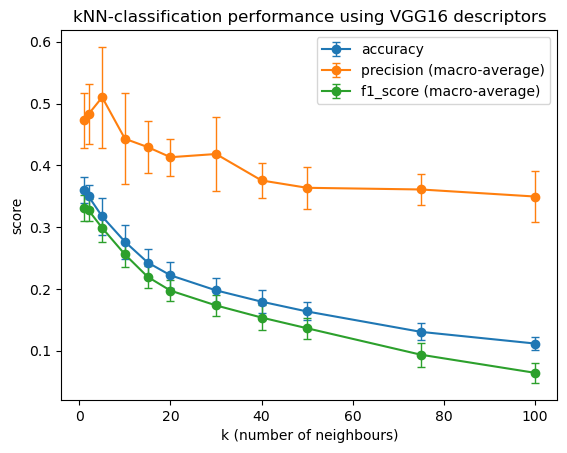

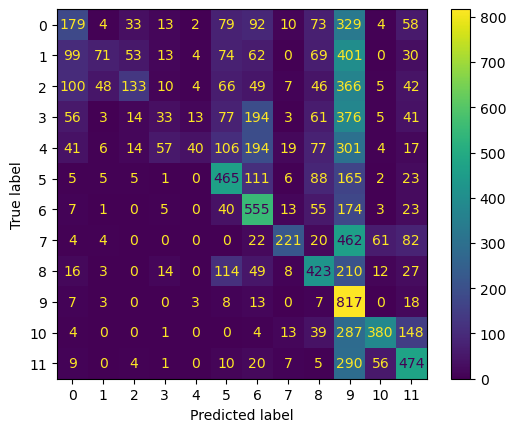

InceptionV3 accuracy for 1-neighbor classification: 0.5963660578386606
InceptionV3 accuracy for 2-neighbor classification: 0.5964611872146118
InceptionV3 accuracy for 5-neighbor classification: 0.6268074581430746
InceptionV3 accuracy for 10-neighbor classification: 0.648972602739726
InceptionV3 accuracy for 15-neighbor classification: 0.6524923896499238
InceptionV3 accuracy for 20-neighbor classification: 0.6590563165905632
InceptionV3 accuracy for 30-neighbor classification: 0.6533485540334856
InceptionV3 accuracy for 40-neighbor classification: 0.6458333333333334
InceptionV3 accuracy for 50-neighbor classification: 0.6420281582952816
InceptionV3 accuracy for 75-neighbor classification: 0.628900304414003
InceptionV3 accuracy for 100-neighbor classification: 0.617579908675799
InceptionV3 precision for 1-neighbor classification: 0.6112179445247475
InceptionV3 precision for 2-neighbor classification: 0.6105908257228913
InceptionV3 precision for 5-neighbor classification: 0.63120358235531

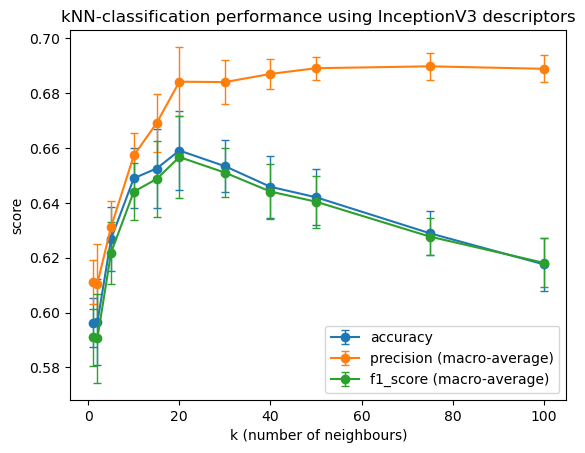

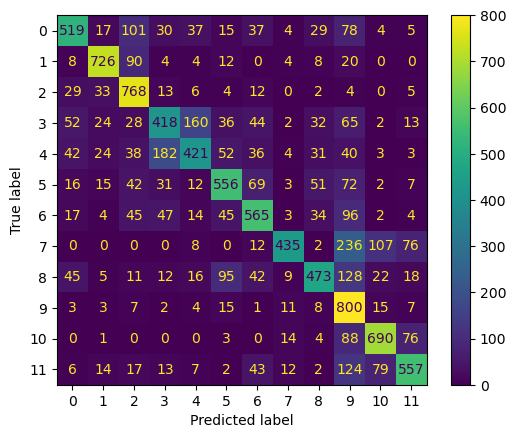

100%|██████████| 492/492 [00:14<00:00, 33.83it/s]


ResNet-50 accuracy for 1-neighbor classification: 0.7249809741248098
ResNet-50 accuracy for 2-neighbor classification: 0.723744292237443
ResNet-50 accuracy for 5-neighbor classification: 0.738013698630137
ResNet-50 accuracy for 10-neighbor classification: 0.752568493150685
ResNet-50 accuracy for 15-neighbor classification: 0.762652207001522
ResNet-50 accuracy for 20-neighbor classification: 0.7577054794520548
ResNet-50 accuracy for 30-neighbor classification: 0.7473363774733638
ResNet-50 accuracy for 40-neighbor classification: 0.7403919330289194
ResNet-50 accuracy for 50-neighbor classification: 0.7330669710806698
ResNet-50 accuracy for 75-neighbor classification: 0.7146118721461188
ResNet-50 accuracy for 100-neighbor classification: 0.6992009132420092
ResNet-50 precision for 1-neighbor classification: 0.7423446581622068
ResNet-50 precision for 2-neighbor classification: 0.7445517130156841
ResNet-50 precision for 5-neighbor classification: 0.7476837118769585
ResNet-50 precision for 10

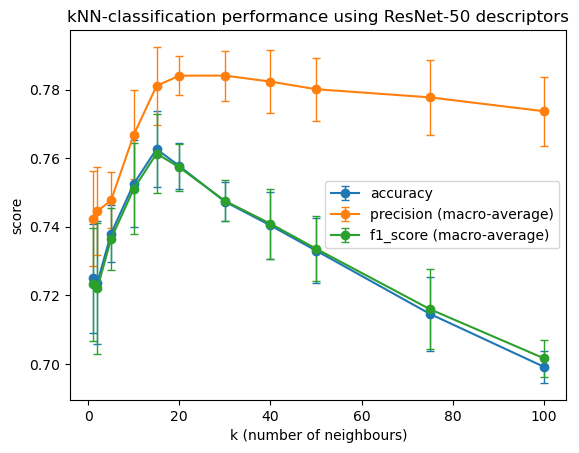

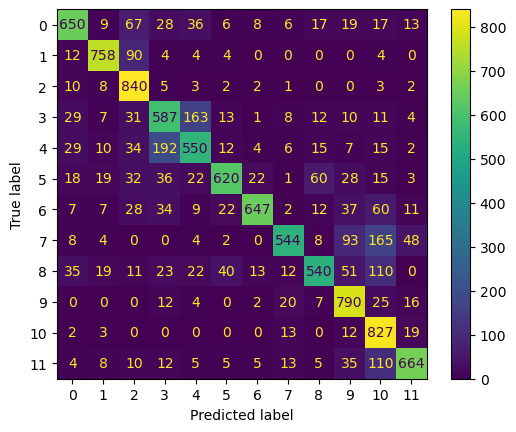

100%|██████████| 492/492 [00:13<00:00, 35.72it/s]


ResNet-18 accuracy for 1-neighbor classification: 0.691400304414003
ResNet-18 accuracy for 2-neighbor classification: 0.695300608828006
ResNet-18 accuracy for 5-neighbor classification: 0.7247907153729072
ResNet-18 accuracy for 10-neighbor classification: 0.7254566210045662
ResNet-18 accuracy for 15-neighbor classification: 0.7298325722983258
ResNet-18 accuracy for 20-neighbor classification: 0.7328767123287672
ResNet-18 accuracy for 30-neighbor classification: 0.7304033485540334
ResNet-18 accuracy for 40-neighbor classification: 0.7285007610350076
ResNet-18 accuracy for 50-neighbor classification: 0.7236491628614916
ResNet-18 accuracy for 75-neighbor classification: 0.7111872146118722
ResNet-18 accuracy for 100-neighbor classification: 0.7049086757990868
ResNet-18 precision for 1-neighbor classification: 0.7161482188635205
ResNet-18 precision for 2-neighbor classification: 0.7161054311106324
ResNet-18 precision for 5-neighbor classification: 0.7402696694085024
ResNet-18 precision for 

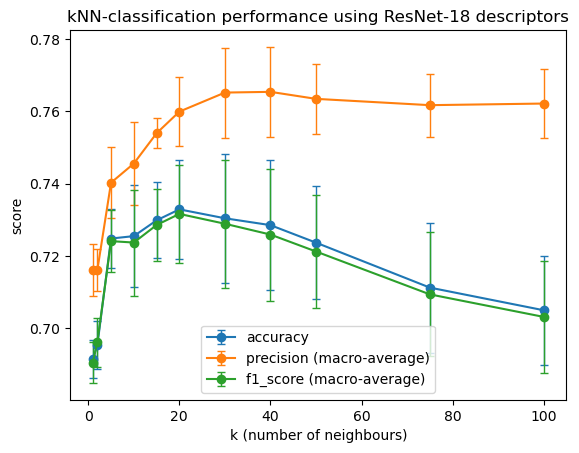

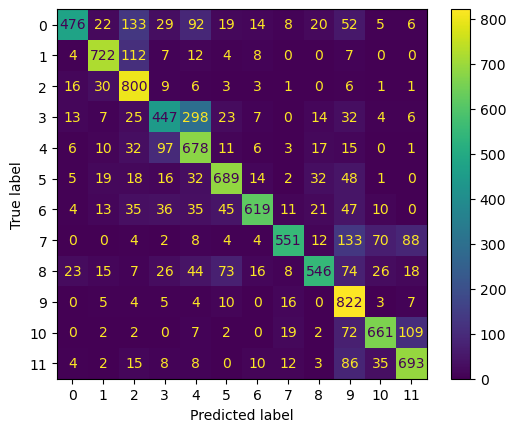

In [19]:
for model in models:
    descriptor_manager = DescriptorManager(model)
    descriptor_assessor = DescriptorAssessor(descriptor_manager)

    (
        targets,
        predictions,
        accuracies,
        accuracies_stdev,
        precisions,
        precisions_stdev,
        f1_scores,
        f1_scores_stdev
    ) = descriptor_assessor.assess_kfold(
        dataset,
        n_neighbors_list
    )

    visualiser = Visualiser(model)
    visualiser.visualise_metrics_per_n(
        accuracies,
        accuracies_stdev,
        precisions,
        precisions_stdev,
        f1_scores,
        f1_scores_stdev
    )

    best_n_test = max(
        accuracies,
        key=accuracies.get
    )

    cm = confusion_matrix(
        np.concatenate(list(targets.values())),
        np.concatenate(list(predictions[best_n_test].values()))
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

### Visually assess predicted vs. target through PCA

In [20]:
def plot_predictions_against_targets(fit_pca,
                                     predictions,
                                     targets,
                                     n_classes,
                                     cmap=None):
    """Draws a scatter plot of two-dimensional data which highlights
    differences between targets and predictions through distinct edge and fill
    colors."""

    if cmap is None:
        cmap = plt.get_cmap("rainbow")

    if isinstance(targets, list):
        targets = np.array(targets)

    colors_target = cmap(targets / n_classes)
    colors_predictions = cmap(predictions / n_classes)

    fig, ax = plt.subplots()
    # Plot targets (ground truth) with fill color representing target class
    ax.scatter(fit_pca[:, 0],
               fit_pca[:, 1],
               facecolors=colors_target,
               label="target")

    # Plot predictions with edge color representing predicted class
    ax.scatter(fit_pca[:, 0],
               fit_pca[:, 1],
               facecolors="none",
               edgecolors=colors_predictions,
               label="predicted")

    legend = ax.legend()
    # Set colors to black to indicate the legend is about marker type, rather
    # than color
    legend.legendHandles[0].set_color("black")
    legend.legendHandles[1].set_edgecolor("black")

    return (fig, ax)